----------------------------------------------
-- Age Predict (Original) - Stats
--
- MAE (mean abs error) : 5.691028088289773
- ME (mean error)      : 0.5400400732090808
- STDev (standard dev) : 5.836235949832943


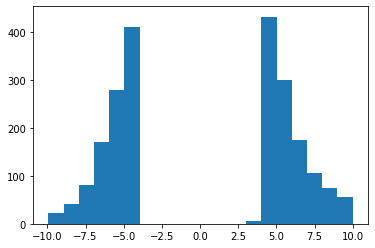

In [1]:
import shutil

# importing the sys module
import sys        
 
# appending the directory of mod.py
# in the sys.path list
sys.path.append('../')  

import json

import torch
from PIL import Image

from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler

from range_classification__dataset import RangeClassificationSameUniformDiffDataset, RangeClassificationMixedUniformDiffDataset, RangeClassificationMimicDiffDataset



from Common.Analysis.DiffAnalysisMethods import diff_dataset_stats
from Common.Analysis.RegAnalysisMethods import age_predict_stats
from Common.Datasets.Morph2.data_parser import DataParser
from range_classification__dataset import get_error_constrained_dataset


import range_classification__config as cfg

if __name__ == "__main__":

#     if cfg.USE_GPU:
#         device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     else:
    device = torch.device("cpu")

#     print(device)

#     torch.cuda.empty_cache()

    #####################################################
    #           Data Loading
    #####################################################

    with open("im2age_map_test.json", 'r') as im2age_map_test_f:
        im2age_map_test = json.load(im2age_map_test_f)

    # Load data
    data_parser = DataParser('../Common/Datasets/Morph2/aligned_data/aligned_dataset_with_metadata_uint8.hdf5', small_data=cfg.SMALL_DATA)
    data_parser.initialize_data()


    x_train, y_train, x_test, y_test = data_parser.x_train,	data_parser.y_train, data_parser.x_test, data_parser.y_test,
    

    x_test_filtered, y_test_filtered, batst_set_filtered_indexes = get_error_constrained_dataset(orig_dataset_images=x_test, 
                                                                                                    orig_dataset_metadata=y_test,
                                                                                                    age_diff_learn_radius_lo=4,#cfg.AGE_DIFF_LEARN_RADIUS_LO,
                                                                                                    age_diff_learn_radius_hi=10,#cfg.AGE_DIFF_LEARN_RADIUS_HI,
                                                                                                    im2age_map_batst=im2age_map_test)

    # get stats on filtered dataset - performance of AgePredict()
    age_predict_stats(dataset_metadata=y_test_filtered, 
                        dataset_indexes=batst_set_filtered_indexes,
                        im2age_map_batst=im2age_map_test)

C:\Users\proj\.conda\envs\my_thesis_py38\lib\site-packages\torchvision\transforms\transforms.py:1361: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


Training (q trn, r trn) set size: 44285


  0%|                                                                                         | 0/5535 [00:00<?, ?it/s]

Testing (q tst where AgePredict(q)  0 <= error <= 35, r trn where age(r)=AgePredict(q)) set size: 2157


100%|██████████████████████████████████████████████████████████████████████████████| 5535/5535 [10:01<00:00,  9.20it/s]


----------------------------------------------
-- Diff Dataset (train)- Stats
--
- ME (mean error)      : -0.46142728093947605
- STDev (standard dev) : 12.356137013704641


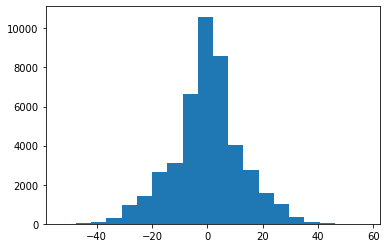

100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.67it/s]


----------------------------------------------
-- Diff Dataset (val_apref_ds)- Stats
--
- ME (mean error)      : 0.5562267657992565
- STDev (standard dev) : 5.832752533716906


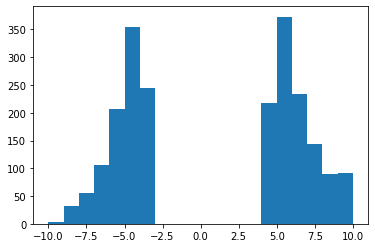

In [2]:
transf = transforms.Compose([
        transforms.RandomResizedCrop(224, (0.9, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(
            brightness=0.1,
            contrast=0.1,
            saturation=0.1,
            hue=0.1
        )], p=0.5),
        transforms.RandomApply([transforms.RandomAffine(
            degrees=10,
            translate=(0.1, 0.1),
            scale=(0.9, 1.1),
            shear=5,
            resample=Image.BICUBIC
        )], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.5)
    ])

train_ds = RangeClassificationSameUniformDiffDataset(
    data_set_images=x_train,
    data_set_metadata=y_train,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_radius=cfg.AGE_RADIUS,
    age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
    age_diff_learn_radius_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI
)

print("Training (q trn, r trn) set size: " + str(len(train_ds)))

# test_qtst_rtst_ds = RangeClassificationSameUniformDiffDataset(
#     data_set_images=x_test,
#     data_set_metadata=y_test,
#     min_age=cfg.MIN_AGE,
#     age_interval=cfg.AGE_INTERVAL,
#     max_age=cfg.MAX_AGE,
#     transform=transf,
#     copies=1, 
#     age_radius=cfg.AGE_RADIUS,
#     age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
#     age_diff_learn_radius_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI
# )

# print("Testing (q tst, r tst) set size: " + str(len(test_qtst_rtst_ds)))

# test_qtst_rtrn_ds = RangeClassificationMixedUniformDiffDataset(
#     batrn_set_images=x_train,
#     batrn_set_metadata=y_train,
#     batst_set_images=x_test,
#     batst_set_metadata=y_test,
#     min_age=cfg.MIN_AGE,
#     age_interval=cfg.AGE_INTERVAL,
#     max_age=cfg.MAX_AGE,
#     transform=transf,
#     copies=1, 
#     age_radius=cfg.AGE_RADIUS,
#     age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
#     age_diff_learn_radius_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI
# )

# print("Testing (q tst, r trn) set size: " + str(len(test_qtst_rtrn_ds)))

# apref = Age Predict Reference (dataset is based on (q,r) pairs where r's age is what AgePredict model returns on q)
test_apref_ds = RangeClassificationMimicDiffDataset(
    batrn_set_images=x_train,
    batrn_set_metadata=y_train,
    batst_set_images=x_test_filtered,
    batst_set_metadata=y_test_filtered,
    batst_set_indexes=batst_set_filtered_indexes,
    im2age_map_batst=im2age_map_test,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_radius=cfg.AGE_RADIUS
)

print("Testing (q tst where AgePredict(q)  {age_diff_learn_radius_lo} <= error <= {age_diff_learn_radius_hi}, r trn where age(r)=AgePredict(q)) set size: ".format(age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO, age_diff_learn_radius_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI) + str(len(test_apref_ds)))


image_datasets = {
    'train': train_ds,
#     'val_qtst_rtst': test_qtst_rtst_ds,
#     'val_qtst_rtrn': test_qtst_rtrn_ds,
    'val_apref_ds': test_apref_ds
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train',  'val_apref_ds']} # 'val_qtst_rtst', 'val_qtst_rtrn',

data_loaders = {
    'train': DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=True, drop_last=True),
#     'val_qtst_rtst': DataLoader(test_qtst_rtst_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True),
#     'val_qtst_rtrn': DataLoader(test_qtst_rtrn_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True),
    'val_apref_ds': DataLoader(test_apref_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True)
}

for dl_key in data_loaders.keys():
    diff_dataset_stats(data_loaders[dl_key], dl_key, device)